In [1]:
from torch_snippets import *

import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

from engine import train_one_epoch, evaluate
import utils
import transforms as T

if torch.cuda.is_available():
    device = 'cuda'
else: 
    device = 'cpu'

C:\Users\olive\miniconda3\envs\torch_env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
all_images = Glob('images/training')
all_annots = Glob('annotations_instance/training')
print(all_images[:10])

[]

In [3]:
classes_list = [4,6]
annots = []
for ann in Tqdm(all_annots):
    _ann = read(ann, 1).transpose(2,0,1)
    r,g,b = _ann
    if np.array([num in np.unique(r) for num in classes_list]).sum()==0: continue
    annots.append(ann)
from sklearn.model_selection import train_test_split
_annots = stems(annots)
trn_items, val_items = train_test_split(_annots, random_state=2)

100%|████████████████████████████████████| 20210/20210 [02:03<00:00, 164.30it/s]


In [4]:
def get_transform(train):
    transforms = []
    transforms.append(T.PILToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [5]:
def get_mask(path):
    an = read(path, 1).transpose(2,0,1)
    r,g,b = an
    cls = list(set(np.unique(r)).intersection({4,6}))
    print(cls)
    masks = []
    labels = []
    for _cls in cls:
      nzs = np.nonzero(r==_cls)
      instances = np.unique(g[nzs])
      for ix,_id in enumerate(instances):
          masks.append(g==_id)
          labels.append(classes_list.index(_cls)+1)
    return np.array(masks), np.array(labels)

In [6]:
_id = trn_items[10]
img_path = f'images/training/{_id}.jpg'

In [7]:
class MasksDataset(Dataset):
    def __init__(self, items, transforms, N):
        self.items = items
        self.transforms = transforms 
        self.N = N

In [8]:
get_mask(img_path)
    

[4, 6]

(array([[[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]],
 
        [[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]],
 
        [[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, 

══════════════════════════════════════════════════════════════════

Tensor  Shape: torch.Size([3, 288, 384])        Min: 0.000      Max: 255.000    Mean: 87.166    dtype: 
torch.float32 @ cpu

══════════════════════════════════════════════════════════════════

dict of 6 items

BOXES:
        Tensor  Shape: torch.Size([7, 4])       Min: 2.000      Max: 369.000    Mean: 205.143   dtype: 
torch.float32 @ cpu

LABELS:
        Tensor  Shape: torch.Size([7])  Min: 1.000      Max: 1.000      Mean: 1.000     dtype: torch.int64 @ cpu

MASKS:
        Tensor  Shape: torch.Size([7, 288, 384])        Min: 0.000      Max: 1.000      Mean: 0.010     dtype: 
torch.float32 @ cpu

IMAGE_ID:
        Tensor  Shape: torch.Size([1])  Min: 1.000      Max: 1.000      Mean: 1.000     dtype: torch.int64 @ cpu

AREA:
        Tensor  Shape: torch.Size([7])  Min: 315.000    Max: 2982.000   Mean: 1835.714  dtype: torch.float32 @ cpu

... ... 1 more item(s)

══════════════════════════════════════════════════════════════════

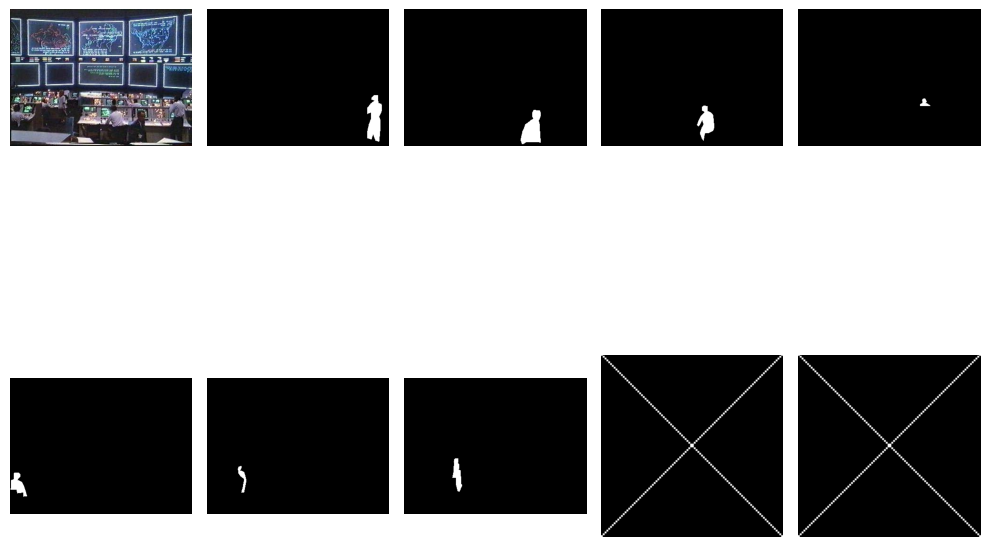

In [9]:
class MasksDataset(Dataset):
    def __init__(self, items, transforms, N):
        self.items = items
        self.transforms = transforms
        self.N = N
        
    def get_mask(self,path):
        an = read(path, 1).transpose(2,0,1)
        r,g,b = an
        cls = list(set(np.unique(r)).intersection({4,6}))
        masks = []
        labels = []
        for _cls in cls:
            nzs = np.nonzero(r==_cls)
            instances = np.unique(g[nzs])
            for ix,_id in enumerate(instances):
                masks.append(g==_id)
                labels.append(classes_list.index(_cls)+1)
        return np.array(masks), np.array(labels)
    
    def __getitem__(self, ix):
        _id = self.items[ix]
        img_path = f'images/training/{_id}.jpg'
        mask_path = f'annotations_instance/training/{_id}.png'
        masks, labels = self.get_mask(mask_path)
        #print(labels)
        obj_ids = np.arange(1, len(masks)+1)
        img = Image.open(img_path).convert("RGB")
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            obj_pixels = np.where(masks[i])
            xmin = np.min(obj_pixels[1])
            xmax = np.max(obj_pixels[1])
            ymin = np.min(obj_pixels[0])
            ymax = np.max(obj_pixels[0])
            if (((xmax-xmin)<=10) | (ymax-ymin)<=10):
                xmax = xmin+10
                ymax = ymin+10
            boxes.append([xmin, ymin, xmax, ymax])
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.float32)
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
        image_id = torch.tensor([ix])
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
        if self.transforms is not None:
            img, target = self.transforms(img, target)
        return img.float(), target
    
    def __len__(self):
        return self.N
    
    def choose(self):
        return self[randint(len(self))]
    
    def collate_fn(self, batch):
        return tuple(zip(*batch))

x = MasksDataset(trn_items, get_transform(train=True), N=100)
im,targ = x[1]
inspect(im,targ)
subplots([im, *targ['masks']], sz=10)

In [10]:
def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,num_classes)
    return model

In [11]:
model = get_model_instance_segmentation(3).to(device)

/opt/homebrew/Caskroom/miniconda/base/envs/torch_env/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/torch_env/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [12]:
dataset = MasksDataset(trn_items, get_transform(train=True), N=3000)
dataset_test = MasksDataset(val_items, get_transform(train=False), N=800)

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=0,
    collate_fn=dataset.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=0,
    collate_fn=dataset_test.collate_fn)

In [13]:
num_classes = 3
model = get_model_instance_segmentation(num_classes).to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)
# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                step_size=3,
                                                gamma=0.1)

In [14]:
model.eval()
norm = torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
norm(dataset[0][0][None].float())
#print(dataset[0][0][None])
#print(dataset[0][0][None].dtype)
pred = model(dataset[0][0][None].float().to(device))
inspect(pred[0])

══════════════════════════════════════════════════════════════════

dict of 4 items

BOXES:
        Tensor  Shape: torch.Size([100, 4])     Min: 0.000      Max: 683.000    Mean: 317.064   dtype: 
torch.float32 @ cpu

LABELS:
        Tensor  Shape: torch.Size([100])        Min: 2.000      Max: 2.000      Mean: 2.000     dtype: torch.int64 
@ cpu

SCORES:
        Tensor  Shape: torch.Size([100])        Min: 1.000      Max: 1.000      Mean: 1.000     dtype: 
torch.float32 @ cpu

MASKS:
        Tensor  Shape: torch.Size([100, 1, 512, 683])   Min: 0.000      Max: 1.000      Mean: 0.001     dtype: 
torch.float32 @ cpu

══════════════════════════════════════════════════════════════════

In [18]:
device

'cpu'

In [16]:
num_epochs = 5

trn_history = []
for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    res = train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    trn_history.append(res)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    res = evaluate(model, data_loader_test, device=device)

Epoch: [0]  [   0/1500]  eta: 2:38:31  lr: 0.000010  loss: 346.5615 (346.5615)  loss_classifier: 141.6121 (141.6121)  loss_box_reg: 1.4028 (1.4028)  loss_mask: 191.8069 (191.8069)  loss_objectness: 9.4479 (9.4479)  loss_rpn_box_reg: 2.2919 (2.2919)  time: 6.3410  data: 0.0176
Epoch: [0]  [  10/1500]  eta: 2:02:09  lr: 0.000060  loss: 153.9324 (145.8182)  loss_classifier: 1.9322 (14.2759)  loss_box_reg: 0.5627 (0.7677)  loss_mask: 17.6234 (43.1251)  loss_objectness: 38.3955 (82.2929)  loss_rpn_box_reg: 1.9444 (5.3566)  time: 4.9192  data: 0.0288
Epoch: [0]  [  20/1500]  eta: 1:54:52  lr: 0.000110  loss: 35.8669 (89.2856)  loss_classifier: 1.4872 (8.5358)  loss_box_reg: 0.1985 (0.5261)  loss_mask: 5.5280 (24.7395)  loss_objectness: 16.4187 (48.5130)  loss_rpn_box_reg: 1.1566 (6.9712)  time: 4.5732  data: 0.0265
Epoch: [0]  [  30/1500]  eta: 1:53:56  lr: 0.000160  loss: 7.4578 (64.7114)  loss_classifier: 0.6568 (5.9962)  loss_box_reg: 0.1353 (0.3899)  loss_mask: 1.1301 (17.0349)  loss_obj

SystemExit: 1

/opt/homebrew/Caskroom/miniconda/base/envs/torch_env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3441: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


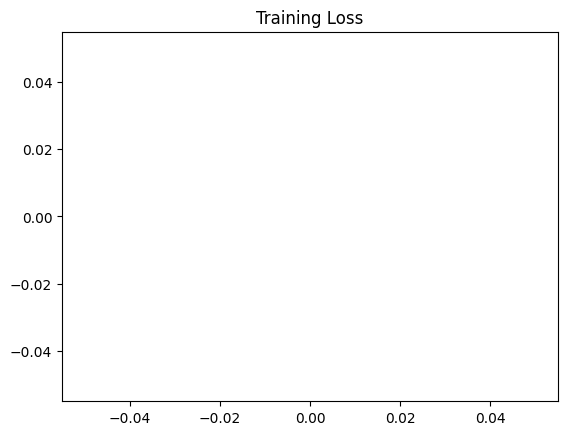

In [19]:
import matplotlib.pyplot as plt
plt.title('Training Loss')
losses = [np.mean(list(trn_history[i].meters['loss'].deque)) for i in range(len(trn_history))]
plt.plot(losses)

In [20]:

k=423

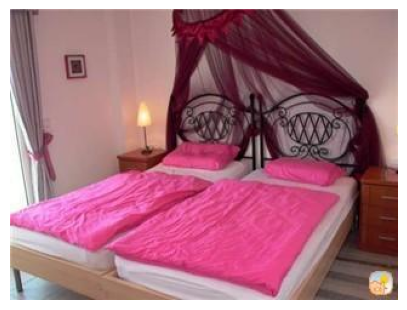

In [21]:
model.eval()
k+=1
im = dataset_test[k][0]
show(im,sz=5)
with torch.no_grad():
    prediction = model([im.to(device)])
    for i in range(len(prediction[0]['masks'])):
        plt.imshow(Image.fromarray(prediction[0]['masks'][i, 0].mul(255).byte().cpu().numpy()))
        plt.title('Class: '+str(prediction[0]['labels'][i].cpu().numpy())+' Score:'+str(prediction[0]['scores'][i].cpu().numpy()))
        plt.show()

# Inspect the Data Loader

In [110]:

for imgs, targets in data_loader:
    break
    

In [125]:
item = targets[1]["iscrowd"]

print(type(item), item.dtype, item.shape, item.max(), item.min())

<class 'torch.Tensor'> torch.int64
torch.Size([2])
tensor i64 0 tensor i64 0